In [37]:
import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt

In [38]:
def game_over(game_board):
    if np.max(np.sum(game_board, axis=1)) == 3:
        return True, 1

    elif np.max(np.sum(game_board, axis=0)) == 3:
        return True, 1
    
    elif np.trace(game_board) == 3:
        return True, 1

    elif np.min(np.sum(game_board, axis=1)) == -3:
        return True, -1

    elif np.min(np.sum(game_board, axis=0)) == -3:
        return True, -1

    elif np.trace(game_board) == -3:
        return True, -1
    
    elif np.count_nonzero(game_board) == 9:
        return True, 0

    return False , 0

In [39]:
class AI:
    def __init__(self, epsilon, player, learning_rate):
        self.q_table = {}
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.player = player
        self.move_history = []
        self.round = 0

    def move(self, board_state):
        new_board_state = self.q_table_update(board_state)
        possible_moves = [index for index, value in enumerate(board_state.flatten().astype(int)) if value == 0]
        if np.random.random() < self.epsilon:
            flatten_move = np.random.choice(possible_moves)
        else:
            flatten_move = np.nanargmax(new_board_state)
        self.round += 1

        if self.round % 1000 == 0:
            self.epsilon *= 0.9


        move = flatten_move // 3, flatten_move % 3
        self.move_history.append(move)
        return move 

    def q_table_update(self, board_state):

        q_key = ''.join(str(x) for x in board_state.flatten())
        try:
            state = self.q_table[q_key]
            return state
        except KeyError:
            self.q_table[q_key] = self.possible_random_moves(board_state)
            state = self.q_table[q_key]
            return state

    def possible_random_moves(self, board_state):
        moves = np.zeros((3,3))
        for i in range(3):
            for j in range(3):
                if board_state[i][j] != 0:
                    moves[i][j] = np.nan
        return moves

    def update_reward(self, results, history, player):
        results *= (player*10)
        for i in range(len(history)):
            moves = self.move_history[-(i+1)]
            if i == 0:
                current = self.q_table[history[-(i+1)]][moves[0]][moves[1]]
                self.q_table[history[-(i+1)]][moves[0]][moves[1]] = current + results - current
            else:
                current = self.q_table[history[-(i+1)]][moves[0]][moves[1]]
                past = np.nanmax(self.q_table[history[-(i)]])
                self.q_table[history[-(i+1)]][moves[0]][moves[1]] = current + self.learning_rate*(results + past - current)

In [40]:
class tictactoe:
    def __init__(self):
        self.board_state = np.zeros((3,3), dtype=int)
        self.board_history1 = []
        self.board_history2 = []

    def get_board_state(self):
        return self.board_state
    
    def update_board_state(self, move, player):
        if player == 1:
            self.board_history1.append(''.join(str(x) for x in self.board_state.flatten()))
        else:
            self.board_history2.append(''.join(str(x) for x in self.board_state.flatten()))
        self.board_state[move] = player

In [41]:
def training_round(player1, player2):
    
    board = tictactoe()
    i = 0
    win1, win2 , draw = 0, 0, 0
    while True:

        #Make a epislon move and return the move    
        move1 = player1.move(board.get_board_state())
        
        # Update the board_state
        board.update_board_state(move1, player1.player)

        #Check if game over and return result
        game_status, result = game_over(board.get_board_state())

        if game_status:
            player1.update_reward(result, board.board_history1, player1.player)
            player2.update_reward(result, board.board_history2, player2.player)
            if result == 1:
                win1 = 1
                return win1, win2, draw
            if result == -1:
                win2 = 1
                return win1, win2, draw
            if result == 0:
                draw = 1
                return win1, win2, draw

        #Make a epislon move and return the move    
        move2 = player2.move(board.get_board_state())

        # Update the board_state
        board.update_board_state(move2, player2.player)

        #Check if game over and return result
        game_status, result = game_over(board.get_board_state())

        if game_status:
            player1.update_reward(result, board.board_history1, player1.player)
            player2.update_reward(result, board.board_history2, player2.player)
            if result == 1:
                win1 = 1
                return win1, win2, draw
            if result == -1:
                win2 = 1
                return win1, win2, draw
            if result == 0:
                draw = 1
                return win1, win2, draw

In [42]:
epsilon = 1
learning_rate = 0.1

player1 = AI(epsilon = epsilon, player = 1, learning_rate = learning_rate)
player2 = AI(epsilon = epsilon, player = -1, learning_rate = learning_rate)

win_1 = []
win_2 = []
draws = []

n_games = 1000000
for i in trange(n_games):
    win1, win2, draw = training_round(player1, player2)
    win_1.append(win1)
    win_2.append(win2)
    draws.append(draw)

100%|██████████| 1000000/1000000 [20:18<00:00, 820.42it/s]


2825 1102 996073


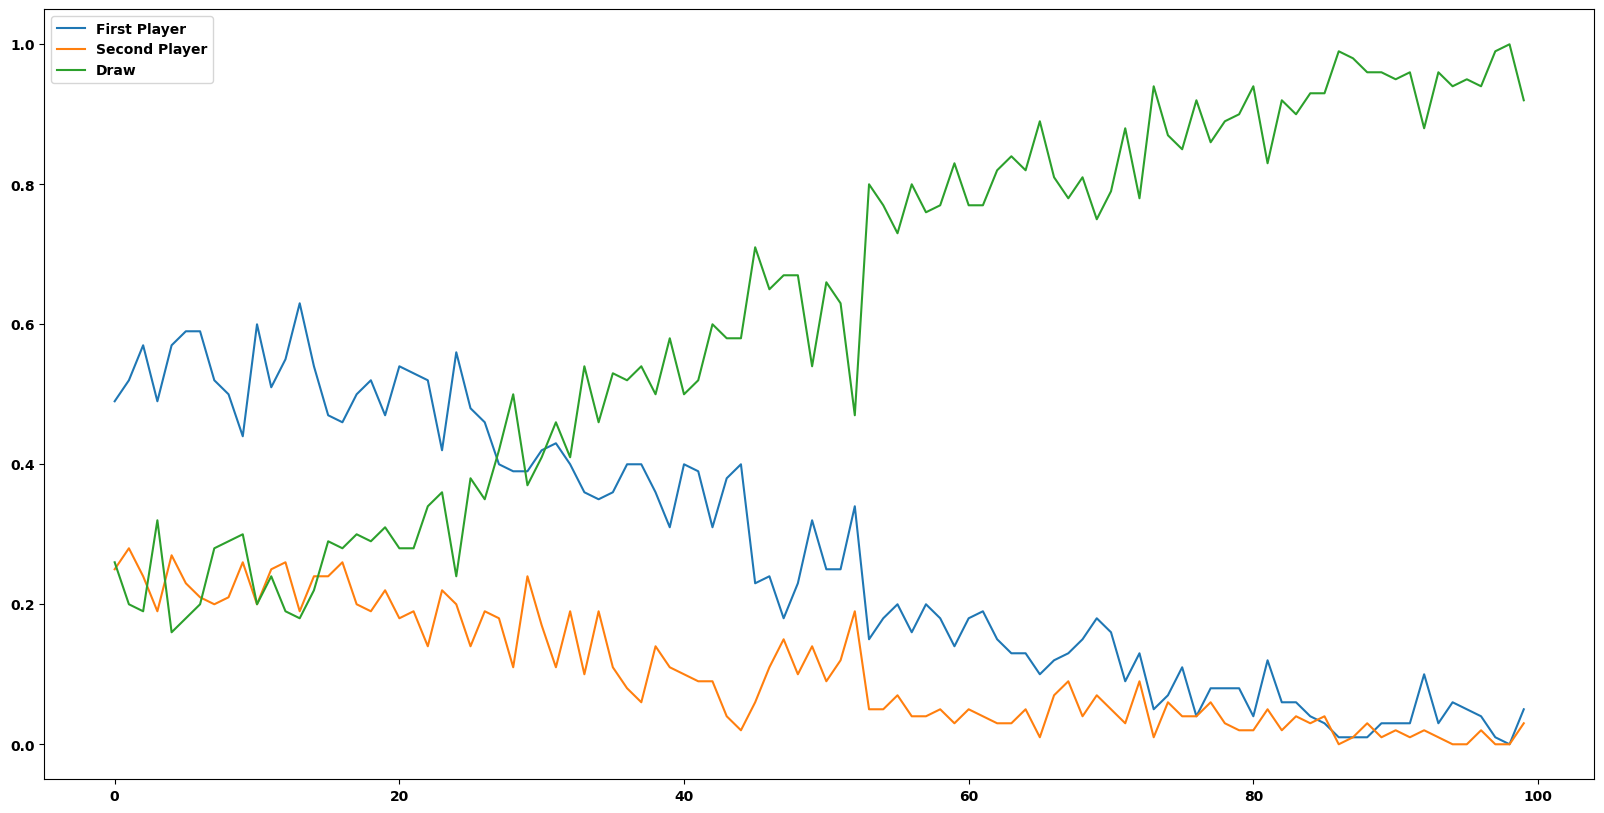

In [51]:
print(np.sum(win_1), np.sum(win_2), np.sum(draws))

win_rate_1 = np.mean(np.array(win_1).reshape(-1, int(n_games/10000)), axis = 1)
win_rate_2 = np.mean(np.array(win_2).reshape(-1, int(n_games/10000)), axis = 1)
win_rate_draw = np.mean(np.array(draws).reshape(-1, int(n_games/10000)), axis = 1)
plt.figure(figsize=(20,10))
plt.plot(win_rate_1[0:100], label = 'First Player')
plt.plot(win_rate_2[0:100], label = 'Second Player')
plt.plot(win_rate_draw[0:100], label = 'Draw')
plt.legend()
plt.show()

In [54]:
def csv_converter(player):
    j = 0
    for key, value in player.q_table.items():
        int_key = []
        for i in range(len(key)):
            if i < len(key):
                if key[i] == '0':
                    int_key.append(0)
                elif key[i] == '1':
                    if key[i-1] == '-':
                        int_key.append(-1)
                    else:
                        int_key.append(1)
        key_array = np.array(int_key).reshape(3,3)
        output = np.vstack((key_array, value))
        if j == 0 :
            outputs = output
        else:
            outputs = np.hstack((outputs, output))
        j += 1
    return outputs

outputs1 = csv_converter(player1)
outputs2 = csv_converter(player2)

np.savetxt('player1.csv', outputs1, delimiter = ',' , fmt='%s')
np.savetxt('player2.csv', outputs2, delimiter = ',' , fmt='%s')